In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Some necessary commands before training.
import os
os.chdir('/content/drive/My Drive/TextSummarization-amazon')
!pip install unidecode
!python -m nltk.downloader stopwords

     |████████████████████████████████| 245kB 4.5MB/s 
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from attention import AttentionLayer
from DataPreprocessing import DataPreprocessing
from TextCleaner import TextCleaner
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

processor = DataPreprocessing()
cleaner = TextCleaner()

# Load pickled Data
data =  processor.load_pickle('DataSequences')

x_tr, x_test, x_dev, y_tr, y_test, y_dev = data[0],data[1],data[2],data[3],data[4],data[5]

loaded_data = processor.load_pickle('TokenizerData')

x_tokenizer, y_tokenizer, x_vocab_size,y_vocab_size, input_word_index,target_word_index, reversed_input_word_index, reversed_target_word_index, max_length_story, max_length_highlight = loaded_data[0],loaded_data[1], loaded_data[2],loaded_data[3],loaded_data[4],loaded_data[5],loaded_data[6],loaded_data[7],loaded_data[8],loaded_data[9]

class Summarizer(): 
    def __init__(self):
        self.latent_dim = 300
        self.embedding_dim = 100
        
    def read_glove_embeddings(self):
        embeddings_index = dict()
        f = open('glove.6B.100d.txt',encoding = 'utf8')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        
        return embeddings_index
    
    def embedding_matrix(self, embeddings_index):
        embedding_matrix_input = np.zeros((x_vocab_size,100))

        for word, idx in input_word_index.items():
            embedding_vector = embeddings_index.get(word)

            if embedding_vector is not None:
                embedding_matrix_input[idx,:] = embedding_vector
            else:
                new_embedding = np.random.uniform(-1,1,(1,100))
                embedding_matrix_input[idx,:] = new_embedding
                
        embedding_matrix_target = np.zeros((y_vocab_size, 100))

        for word, idx in target_word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix_target[idx,:] = embedding_vector
            else:
                new_embedding = np.random.uniform(-1,1,(1,100))
                embedding_matrix_target[idx,:] = new_embedding
                
        return embedding_matrix_input, embedding_matrix_target
    
    
    
    def define_models(self, embedding_matrix_input, embedding_matrix_target):
        """Training Phase"""
        # Encoder
        encoder_inputs = Input(shape = (max_length_story,))
        enc_emb = Embedding(x_vocab_size,self.embedding_dim,weights=[embedding_matrix_input],input_length=max_length_story,trainable=False)(encoder_inputs)
        encoder = Bidirectional(LSTM(self.latent_dim, return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3))
        encoder_outputs,forward_h,forward_c,backward_h,backward_c = encoder(enc_emb)
        state_h = Concatenate()([forward_h,backward_h])
        state_c = Concatenate()([forward_c,backward_c])
        
        # Decoder
        decoder_inputs = Input(shape=(None,))
        dec_emb_layer = Embedding(y_vocab_size,self.embedding_dim,weights=[embedding_matrix_target],input_length=max_length_highlight,trainable=False)
        dec_emb = dec_emb_layer(decoder_inputs)
        decoder_lstm = LSTM(2*self.latent_dim, return_sequences=True,return_state=True,dropout=0.3,recurrent_dropout=0.3)
        decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h,state_c])
        
        # Attention
        attn_layer = AttentionLayer(name='attention_layer')
        attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
        
        # Concatenate the context vectors with the decoder outpouts
        decoder_concat = Concatenate()([decoder_outputs, attn_out])
        
        # Dense
        decoder_dense =  TimeDistributed(Dense(y_vocab_size, activation='softmax'))
        decoder_outputs = decoder_dense(decoder_concat)
        
        # model
        trainer_model = Model(inputs=[encoder_inputs,decoder_inputs],outputs=decoder_outputs)
        
        
        """Inference Phase"""
        # Encoder
        encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
        
        # Decoder
        decoder_state_input_h = Input(shape=(2* self.latent_dim,))
        decoder_state_input_c = Input(shape=(2* self.latent_dim,))
        decoder_hidden_state_input = Input(shape=(max_length_story, 2* self.latent_dim))
        dec_emb2 = dec_emb_layer(decoder_inputs)
        decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h,decoder_state_input_c])

        # Attention 
        attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
        decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
        
        # Dense
        decoder_outputs2 = decoder_dense(decoder_inf_concat)
        decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h,decoder_state_input_c], 
                              [decoder_outputs2] + [state_h2, state_c2])
        
        
        return trainer_model, encoder_model, decoder_model
    
    
    def compile_model(self,model,optimizer='adam',loss='sparse_categorical_crossentropy'):
        model.compile(optimizer, loss)
        
    def train_model(self,model,x_tr,x_dev,y_tr,y_dev,epochs=20,batch_size=128):
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)
        history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=epochs,batch_size=batch_size,callbacks=[es],validation_data=([x_dev,y_dev[:,:-1]], y_dev.reshape(y_dev.shape[0],y_dev.shape[1], 1)[:,1:]))
        
        return history
    
    def diagnostic_plot(self,history):
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='dev')
        plt.legend()
        plt.show()
        
    def save_model(self,encoder_model,decoder_model):
        with open('encoder_model.json', 'w', encoding='utf8') as f:
            f.write(encoder_model.to_json())
        encoder_model.save_weights('encoder_model_weights.h5')

        with open('decoder_model.json', 'w', encoding='utf8') as f:
            f.write(decoder_model.to_json())
        decoder_model.save_weights('decoder_model_weights.h5')

Embedding Vectors Loaded.
Embedding Matrix Created.
Model Defined.
Model Compiled.
Epoch 1/50
644/644 [==============================] - 348s 540ms/step - loss: 3.0883 - val_loss: 2.7719
Epoch 2/50
644/644 [==============================] - 346s 537ms/step - loss: 2.6711 - val_loss: 2.5811
Epoch 3/50
644/644 [==============================] - 343s 533ms/step - loss: 2.4761 - val_loss: 2.4599
Epoch 4/50
644/644 [==============================] - 342s 532ms/step - loss: 2.3260 - val_loss: 2.3968
Epoch 5/50
644/644 [==============================] - 347s 540ms/step - loss: 2.1991 - val_loss: 2.3540
Epoch 6/50
644/644 [==============================] - 345s 535ms/step - loss: 2.0764 - val_loss: 2.3237
Epoch 7/50
644/644 [==============================] - 347s 538ms/step - loss: 1.9569 - val_loss: 2.3141
Epoch 8/50
644/644 [==============================] - 345s 536ms/step - loss: 1.8468 - val_loss: 2.3259
Epoch 9/50
644/644 [==============================] - 342s 531ms/step - loss: 1.7444 

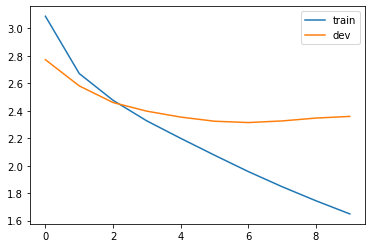

Model Saved.
Model Loaded.
Review: also tried love many energy drinks green monster cannot beat mg ginseng along gms protein building blocks gm energy blend wrapped green pixie stick flavor spectacular rockstar red bull amp sobe many many others cannot compare know monster even green hood car actively search replacements complementary beverages one worthy cannot found anyone feels know drink worthy please post note try loved 
Original summary: the green monster 
Predicted summary: great alternative to the shakes 


Review: plain coconut drink bland guava flavor taste best flavors tried quite refreshing diluted regular water full sugar like flavored water products looking buy get especially get sale guava flavor seems sold one also tried vita coco naked coconut water peach mango flavor like prices higher amazon neighborhood health food stores also used home made vegetable smoothie delicious results would love see offer coconut water larger juice box like oz intense work could use bit wo

In [0]:
class Main():
    # """Data Preprocessing"""
    # from DataPreprocessing import DataPreprocessing
    # processor = DataPreprocessing()
    # # Read-in dataset
    # data = processor.load_dataset('Reviews',100000)
    # print('Dataset Loaded.')
    
    # # remove unnnecessary columns
    # data = processor.remove_columns(data)
    # print("Unnecessary columns removed.")
    
    # # clean data
    # data['Text'], data['Summary'] = processor.clean_data(data)
    # print('Dataset Cleaned.')
    
    # # remove long stories
    # data['Text'], data['Summary'] = processor.remove_long_sequences(data)
    # print('Long Stories Removed.')
    
    # # remove duplicates and na
    # data = processor.drop_dulp_and_na(data, ['Text', 'Summary'])
    # print("Duplicates and NaN dropped.")
        
    # # start and end tokens
    # data['Summary'] = processor.start_end_token(data['Summary'])
    # print("Start and End Tokens added.")
    
    # # Tokenizer
    # total_word, rare_word = processor.rare_words_count(data['Text'])
    # x_seq, x_tokenizer = processor.text2seq(data['Text'], total_word, rare_word)
    # x_seq = processor.pad_seq(x_seq, processor.max_length_text)
    
    # total_word, rare_word = processor.rare_words_count(data['Summary'])
    # y_seq, y_tokenizer = processor.text2seq(data['Summary'], total_word, rare_word)
    # y_seq = processor.pad_seq(y_seq, processor.max_length_summary)
    # ("Tokenization Completed.")
    
    # # Tokenizer Data
    # x_vocab_size, y_vocab_size, input_word_index, target_word_index, reversed_input_word_index, reversed_target_word_index = processor.required_dicts(x_tokenizer,y_tokenizer)
    # ("Tokenizer Data Loaded.")
    
    # # split data
    # x_tr, x_test, x_dev, y_tr, y_test, y_dev = processor.split_data(x_seq, y_seq, train_ratio=0.75, dev_ratio=0.125)
    # print("Data Splitted.")
    
    # # Pickle data required for building model
    # processor.pickle_data([x_tr, x_test, x_dev, y_tr, y_test, y_dev], 'DataSequences')
    # print("Data Sequences Pickled.")
    
    # processor.pickle_data([x_tokenizer, y_tokenizer, x_vocab_size, y_vocab_size, input_word_index, target_word_index, 
    # reversed_input_word_index, reversed_target_word_index,
    # processor.max_length_text, processor.max_length_summary], 'TokenizerData')
    # print("Tokenizer Data Pickled.")
    
    # """Model Building""" 
    # from Summarizer import Summarizer
    summarizer = Summarizer()
    
    # Read in glove embeddinsg
    embeddings_index = summarizer.read_glove_embeddings()
    print("Embedding Vectors Loaded.")
    
    # embedding matrix
    embedding_matrix_input, embedding_matrix_target = summarizer.embedding_matrix(embeddings_index)
    print("Embedding Matrix Created.")
    
    # Define model
    trainer_model, encoder_model, decoder_model = summarizer.define_models(embedding_matrix_input,embedding_matrix_target)
    print("Model Defined.")
    
    # Compile model
    summarizer.compile_model(trainer_model)
    print("Model Compiled.")
    
    # Train model
    history = summarizer.train_model(trainer_model, x_tr, x_dev, y_tr, y_dev,epochs=50,batch_size=64)
    print("Model Trained.")
    
    # Disgnostic plot
    print("Diagnostic Plot: ")
    summarizer.diagnostic_plot(history)
    
    # Save model
    summarizer.save_model(encoder_model, decoder_model)
    print("Model Saved.")
    
    """Predictions"""
    from Prediction import Prediction
    predictor = Prediction()
    
    # Load trained model
    encoder_model = predictor.load_model('encoder_model.json', 'encoder_model_weights.h5')
    decoder_model = predictor.load_model('decoder_model.json', 'decoder_model_weights.h5')
    print("Model Loaded.")
    
    # Generate summaries
    predictor.generated_summaries(3, encoder_model, decoder_model)